## XGBoost algorithm for MNIST - confusion matrix, Random Forest comparison

### package imports, data loading

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import time

In [7]:
data_direcory = "data"
x_train_pca = pd.read_csv(data_direcory + "/x_train_pca_final.csv", header=None)
x_test_pca = pd.read_csv(data_direcory + "/x_test_pca_final.csv", header=None)

#load dataset
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = (x_train / 255.0).reshape([60000, 28*28])
x_test = (x_test / 255.0).reshape([10000, 28*28])

In [8]:
# Use only subset samples for each label
SUBSET_SIZE = 1200
np.random.seed(123)
selected_indeces = []
for label in np.unique(y_train):
    label_indices = np.where(y_train == label)[0]
    subsample_label = np.random.choice(label_indices,size=SUBSET_SIZE)
    selected_indeces.extend(subsample_label)
print("Number of training samples: {}".format(len(selected_indeces)))
print("Only unique values are present: {}".format(len(np.unique(subsample_label)) != len(subsample_label)))

Number of training samples: 12000
Only unique values are present: True


### Comparison of training time:  Random forest classifier vs. XGBoost

In [10]:
x_train_pca_reduced = x_train_pca.iloc[selected_indeces,:]
y_train_pca_reduced = y_train[selected_indeces]

In [12]:
def predict_and_print_accuracy(model, X, Y, accuracy_info="Accuracy"):
    y_pred = model.predict(X)
    predictions = [round(value) for value in y_pred]
    accuracy = metrics.accuracy_score(Y, predictions)
    print("{}:\t{:.2f}%".format(accuracy_info, accuracy * 100.0))

#### Random forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
print("Training set size:\t{}".format(x_train_pca_reduced.shape))
#training
start = time.time()
rf_clf = RandomForestClassifier()
rf_params = {'n_estimators':100}
rf_clf.set_params(**rf_params)
rf_clf.fit(x_train_pca_reduced, y_train_pca_reduced)
end = time.time()
print("Training duration:\t{:.2f} s".format(end - start))

#testing
predict_and_print_accuracy(rf_clf, x_test_pca, y_test,"Testing accuracy")

Training set size:	(12000, 40)
Training duration:	6.22 s
Testing accuracy:	93.61%


#### XGBoost

In [173]:
from xgboost import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #solve kernel problems during XGBoost training

print("Training set size:\t{}".format(x_train_pca_reduced.shape))
#training
start = time.time()
xgb_clf = XGBClassifier()
xgb_params = {'n_estimators': 100, 'eta': 0.01, 'gamma': 0.0, 'max_depth': 6, 'min_child_weight': 4}
xgb_clf.set_params(**xgb_params)
xgb_clf.fit(x_train_pca_reduced, y_train_pca_reduced)
end = time.time()
print("Training duration:\t{:.2f} s".format(end - start))

#testing
predict_and_print_accuracy(xgb_clf, x_test_pca, y_test, "Testing accuracy")

Training set size:	(12000, 40)
Training duration:	75.46 s
Testing accuracy:	93.40%


### Error analysis

#### Confusion matrices

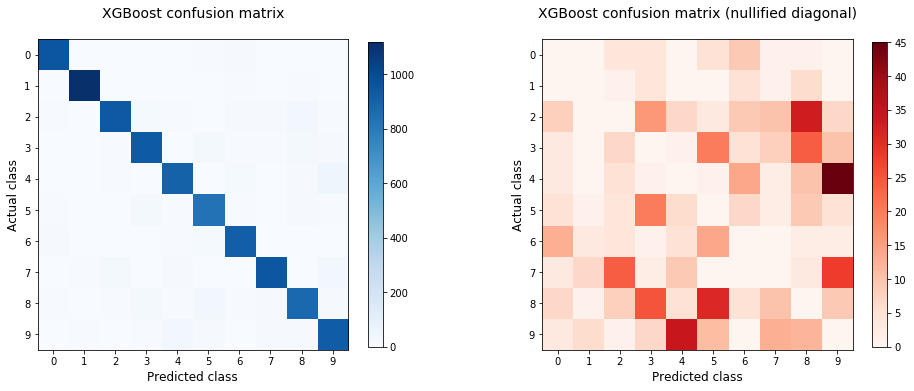

In [163]:
y_pred = [round(value) for value in xgb_clf.predict(x_test_pca)]
conf_mx_xgb = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mx_xgb)

From the confusion matrix on right, it is clear that most samples are correctly classified and there are only few tiles outside the diagonal that are slightly darker than the rest.  
When the diagonal is nullified (right figure), some of the missclassified cases show up. The most problematic case for XGBoost classifier is image with actual class "4" that is predicted as "9" and vice versa. Also classes "3" and "5" are often misclassified. On the other hand numbers "0" and "1" are almost always correctly classified.

In [162]:
def plot_confusion_matrix(conf_mx):
    title_fontsize = 14
    label_fontsize = 12
    colormap_shrink = 0.8
    
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,7), constrained_layout=True)
    plt.subplots_adjust(wspace=0.3)
    
    cm1 = ax1.matshow(conf_mx, cmap=plt.cm.Blues)
    fig.colorbar(cm1,ax=ax1,shrink=colormap_shrink)
    ax1.set_xticks(range(0,10))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_yticks(range(0,10))
    ax1.set_ylabel("Actual class", fontsize=label_fontsize)
    ax1.set_xlabel("Predicted class", fontsize=label_fontsize)
    ax1.set_title("XGBoost confusion matrix", fontsize=title_fontsize)
    
    # nullify the diagonal to get more info about errors
    diag_indices = np.diag_indices(len(conf_mx))
    nullified_conf_mx = np.copy(conf_mx)
    nullified_conf_mx[diag_indices] = 0
    cm2 = ax2.matshow(nullified_conf_mx, cmap=plt.cm.Reds)
    fig.colorbar(cm2,ax=ax2,shrink=colormap_shrink)
    ax2.set_xticks(range(0,10))
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_yticks(range(0,10))
    ax2.set_ylabel("Actual class", fontsize=label_fontsize)
    ax2.set_xlabel("Predicted class", fontsize=label_fontsize)
    ax2.set_title("XGBoost confusion matrix (nullified diagonal)", fontsize=title_fontsize)